## Entraînement du modèle sur Azure Machine Learning

(Ce notebook est à utiliser sur Azure Machine Learning)

On va ici entraîner le meilleur modèle que l'on a sélectionné lors des tests en local.

On upload le jeu de données, et on va l'utiliser dans son entièreté pour entraîner le modèle et obtenir la meilleure précision possible.

In [34]:
from azureml.core import Workspace, Environment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import joblib

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.42.0


## Connexion au workspace

Créer un objet workpsace à partir du workspace existant.

In [12]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

projet_7	westeurope	openclassrooms


## Création d'une "experiment"

Cela sert à traquer et enregistrer ce qu'il se passe durant l'entraînement du modèle


In [13]:
from azureml.core import Experiment
experiment = Experiment(workspace=ws, name="tweets-experiment")

## Récupération du jeu de données

In [14]:
# Charger les données depuis le fichier csv
data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', sep=',', encoding = "ISO-8859-1", header=None, names=['target', 'id', 'date', 'flag', 'user', 'text'])

# Ne garder que les colonnes nécessaires
data = data[["text", "target"]]

# On supprime les tweets en doublons
data.drop_duplicates(subset=['text'], inplace=True)

# Remplacer les valeurs par les vrais labels
data['target'] = data['target'].map(
    {
        0: "NEGATIF",
        4: "POSITIF"
    }
)

# Binarize target
data['target'] = data['target'].map(
    {
        "NEGATIF": 0,
        "POSITIF": 1,
    }
)

data.describe()

,target
count,1.581466e+06
mean,5.003465e-01
std,5.000000e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


## Séparation en jeu d'entraînement et jeu de test

In [29]:
X = data['text']
y = data['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

## Création et entraînement du modèle (Modèle de Deep Learning - bidirectionnal LSTM)

On crée ici le modèle, on l'entraîne avec le jeu d'entraînement.

On récupère certaines métriques puis on sauvegarde le modèle dans un fichier .pkl


In [31]:
# create the model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, Dropout, LSTM, Flatten, Bidirectional, TextVectorization, Activation
from keras.models import Sequential, load_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras.metrics import AUC
import tensorflow as tf

model_name = "bidirectional_lstm"
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

run = experiment.start_logging()

# Define vectorizer
vectorize_layer = TextVectorization(
        output_mode="int",
        max_tokens=max_features,
        output_sequence_length=sequence_length,
    )
vectorize_layer.adapt(
        X,
        batch_size=128,
    )

# define NN model
model = Sequential(name=model_name)
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# Embedding layer
model.add(
        Embedding(
            max_features,
            embedding_dim,
            input_length=sequence_length,
        )
    )

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=rnn_units, dropout=0.2)))

# Dense layers
model.add(Dense(100, input_shape=(max_features,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="relu"))

# Classification layer
model.add(Dense(1, activation="sigmoid"))

# compile NN network
model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            AUC(curve="ROC", name="ROC_AUC"),
            AUC(curve="PR", name="AP"),
        ],
    )


model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=128,
            validation_split=0.2,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=2,
            use_multiprocessing=True,
        )

test_loss, test_accuracy, test_ROC_AUC, test_recall = model.evaluate(X_test, y_test)

run.log("loss", test_loss)
run.log("accuracy", test_accuracy)
run.log("Recall", test_recall)
run.log("ROC_AUC", test_ROC_AUC)

model_name = model_name + ".pkl"
filename = "outputs/" + model_name
    
joblib.dump(value=model, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

Epoch 1/10
7908/7908 [==============================] - 1129s 142ms/step - loss: 0.4270 - accuracy: 0.8021 - ROC_AUC: 0.8845 - AP: 0.8846 - val_loss: 0.3999 - val_accuracy: 0.8169 - val_ROC_AUC: 0.8998 - val_AP: 0.9011
Epoch 2/10
7908/7908 [==============================] - 1116s 141ms/step - loss: 0.3885 - accuracy: 0.8237 - ROC_AUC: 0.9057 - AP: 0.9064 - val_loss: 0.3892 - val_accuracy: 0.8232 - val_ROC_AUC: 0.9056 - val_AP: 0.9066
Epoch 3/10
7908/7908 [==============================] - 1124s 142ms/step - loss: 0.3708 - accuracy: 0.8334 - ROC_AUC: 0.9145 - AP: 0.9154 - val_loss: 0.3844 - val_accuracy: 0.8259 - val_ROC_AUC: 0.9080 - val_AP: 0.9090
Epoch 4/10
7908/7908 [==============================] - 1155s 146ms/step - loss: 0.3564 - accuracy: 0.8406 - ROC_AUC: 0.9213 - AP: 0.9223 - val_loss: 0.3857 - val_accuracy: 0.8265 - val_ROC_AUC: 0.9081 - val_AP: 0.9085

INFO:tensorflow:Assets written to: ram://e55bd5af-004c-43da-8cb3-fe74b8c36844/assets


## Affichage des métriques

In [35]:
test_loss, test_accuracy, test_ROC_AUC, test_recall = model.evaluate(X_test, y_test)

print(f"Loss : {test_loss}")
print(f"Accuracy : {test_accuracy}")
print(f"ROC_AUC : {test_ROC_AUC}")
print(f"Recall : {test_recall}")

9885/9885 [==============================] - 131s 13ms/step - loss: 0.3892 - accuracy: 0.8256 - ROC_AUC: 0.9071 - AP: 0.9074
Loss : 0.38920295238494873
Accuracy : 0.8255926370620728
ROC_AUC : 0.9071202874183655
Recall : 0.9074187278747559


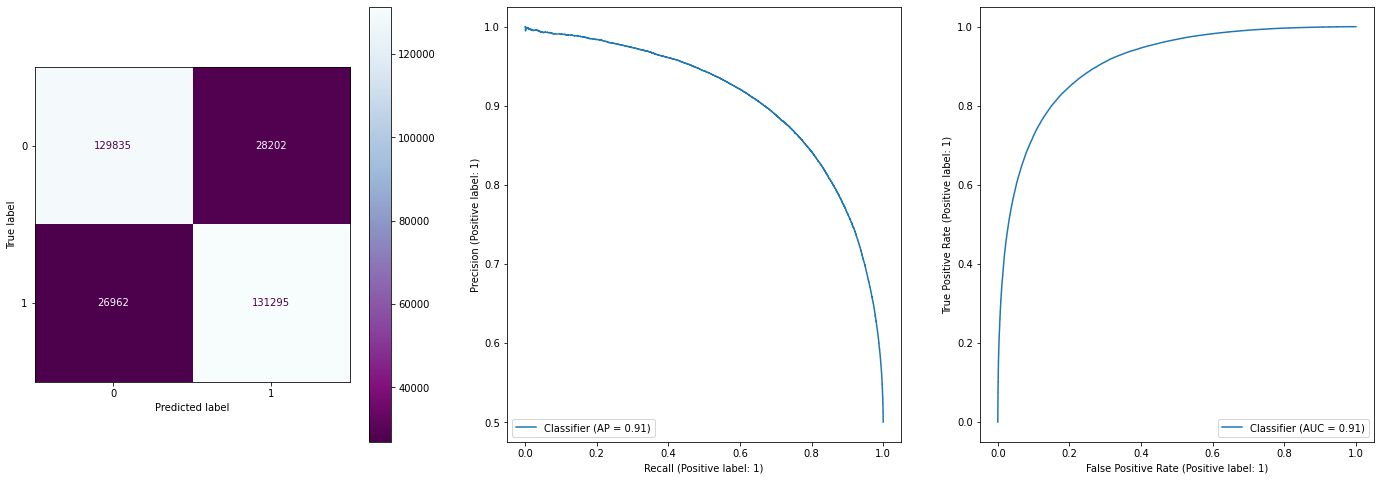

In [37]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)

y_test_pred_proba = model.predict(
    X_test,
    workers=2,
    use_multiprocessing=True,
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

_, ax = plt.subplots(1,3,figsize=(24,8))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap='BuPu_r', ax=ax[0])
PrecisionRecallDisplay.from_predictions(y_test, y_test_pred_proba, ax=ax[1])
RocCurveDisplay.from_predictions(y_test, y_test_pred_proba, ax=ax[2])

plt.show()

## Génération du lien vers le modèle enregistré

In [33]:
experiment

Name,Workspace,Report Page,Docs Page
tweets-experiment,projet_7,Link to Azure Machine Learning studio,Link to Documentation
